In [33]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.rcParams['text.latex.preamble'] = r'\usepackage{times}'

In [1]:
# Evaluate the model
def evaluate_model(model, test_loader, device, verbose=True):
    model.eval()  # Set the model to evaluation mode
    correct, total = 0, 0
    with torch.no_grad():  # No gradient tracking needed
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    if verbose:
        print(f'Accuracy of the model on the test images: {accuracy} %')
    return accuracy

# Model 1

In [3]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models.resnet import ResNet18_Weights

# Load ResNet model
resnet_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = resnet_model.fc.in_features
num_classes = 2  
resnet_model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


model_path = 'model/resnet18_da_1_model_19_88.42.pth'
resnet_model.load_state_dict(torch.load(model_path, map_location=device))
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder

# data transformations
val_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_dataset = datasets.ImageFolder(root='a5_data/val', transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=5)

test_dataset = datasets.ImageFolder(root='a5_data/test', transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=5)

# print Validation Accuracy
# accuracy = evaluate_model(resnet_model, val_loader, device)
# print(f"Validation Accuracy: {accuracy}%")


In [7]:
def generate_labels_and_true(model, loader, device):
    model.eval()  # Set model to evaluation mode
    predicted_labels = []
    true_labels = []
    with torch.no_grad():  # No gradient needed
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predicted_labels.extend(preds.cpu().numpy())  # Move preds to CPU and convert to numpy
            true_labels.extend(labels.cpu().numpy())  # Move true labels to CPU and convert to numpy
    return predicted_labels, true_labels




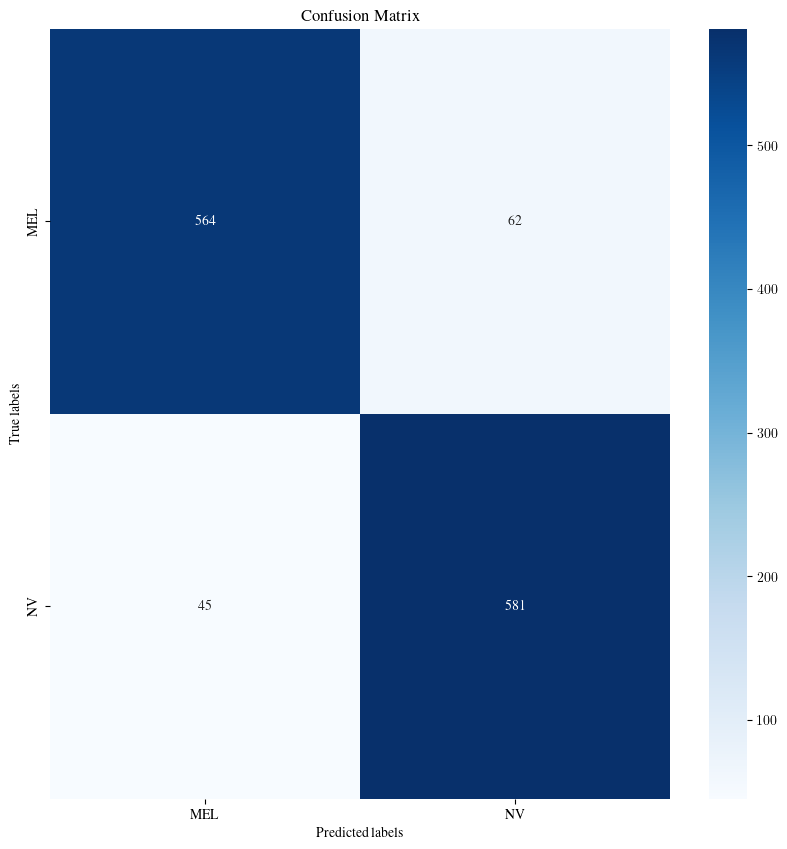

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate the confusion matrix
predicted_labels, true_labels = generate_labels_and_true(resnet_model, val_loader, device)

# 计算混淆矩阵
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", 
            xticklabels=['MEL', 'NV'], yticklabels=['MEL', 'NV'])  # Custom labels for 0 and 1
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show();


In [6]:
# Generate labels for blind test data
from torchvision.datasets import DatasetFolder
from torchvision.transforms.functional import InterpolationMode

test_transforms = transforms.Compose([
    transforms.Resize(128, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(128),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def custom_loader(path):
    return read_image(path)

test_blind_dataset = DatasetFolder(root='a5_data/test_blind', loader=custom_loader, extensions=['png'], transform=test_transforms)
test_blind_loader = DataLoader(test_blind_dataset, batch_size=32, shuffle=False, num_workers=0)

import torch
from torchvision.io import read_image
from torchvision import transforms


predicted_labels, true_labels = generate_labels_and_true(resnet_model, test_blind_loader, device)
print(predicted_labels)

[1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 

In [7]:
with open('labels_test.txt', 'w') as f:
    for label in predicted_labels:
        f.write(f"{'NV' if label else 'MEL'}\n")
        
with open('labels_test.txt') as f:
    guesses = [l.strip() for l in f]
    assert(len(guesses) == 1366)
    assert(sorted(set(guesses)) == ['MEL', 'NV'])

In [8]:
import numpy as np

np.array(predicted_labels).mean()

0.513909224011713

# Model 2


In [4]:
# Load ResNet model
resnet_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = resnet_model.fc.in_features
num_classes = 2  
resnet_model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


model_path = 'model/4_iter__19_91.45.pth'
resnet_model.load_state_dict(torch.load(model_path, map_location=device))
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# print Validation Accuracy
accuracy = evaluate_model(resnet_model, val_loader, device)
print(f"Validation Accuracy: {accuracy}%")

Accuracy of the model on the test images: 91.45367412140575 %
Validation Accuracy: 91.45367412140575%


In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate the confusion matrix
predicted_labels, true_labels = generate_labels_and_true(resnet_model, val_loader, device)
cm = confusion_matrix(true_labels, predicted_labels)

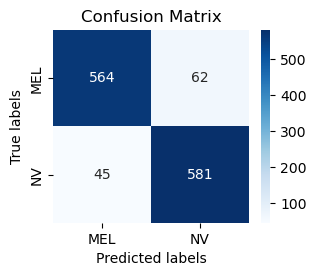

In [12]:
# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(3.15, 2.5))
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", 
            xticklabels=['MEL', 'NV'], yticklabels=['MEL', 'NV'])  # Custom labels for 0 and 1
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show();


In [35]:
# print Validation Accuracy
accuracy = evaluate_model(resnet_model, test_loader, device)
print(f"Validation Accuracy: {accuracy}%")

# Generate the confusion matrix
predicted_labels, true_labels = generate_labels_and_true(resnet_model, test_loader, device)
cm = confusion_matrix(true_labels, predicted_labels)

Accuracy of the model on the test images: 91.28843338213763 %
Validation Accuracy: 91.28843338213763%


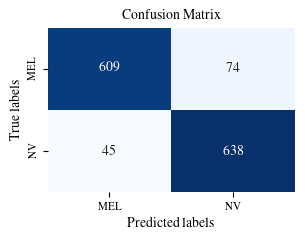

In [36]:
# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(3.15, 2.5))
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", 
            xticklabels=['MEL', 'NV'], yticklabels=['MEL', 'NV'], cbar=False)  # Custom labels for 0 and 1

ax.set_title('Confusion Matrix', fontsize=10)

ax.set_xlabel('Predicted labels', fontsize=10)
ax.set_ylabel('True labels', fontsize=10)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
plt.tight_layout()

plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')
plt.show();


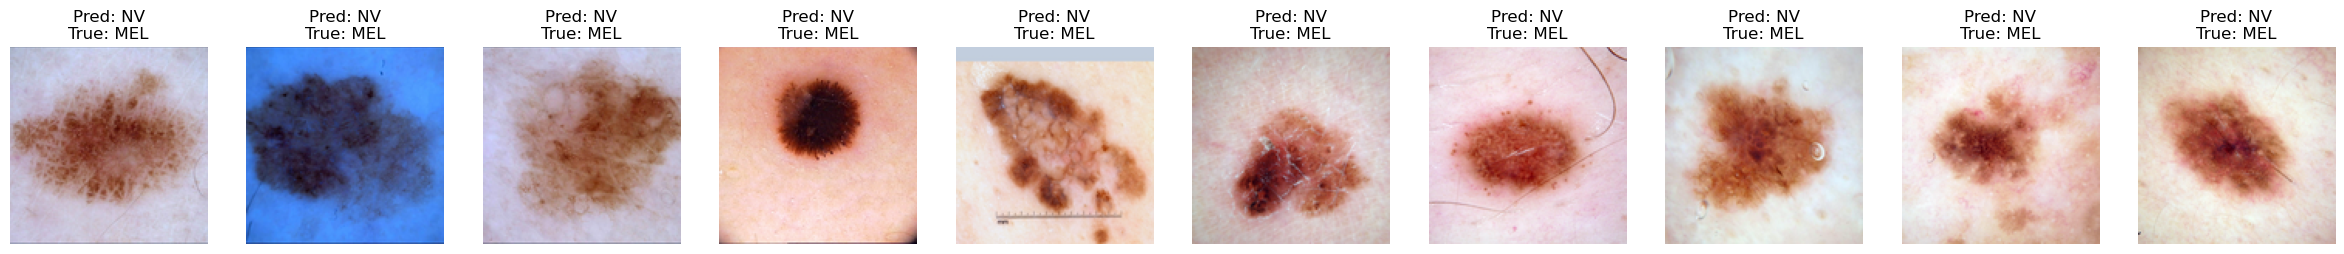

In [13]:
import torch
import matplotlib.pyplot as plt

def plot_misclassified_images(model, loader, device, classes, num_images=10):
    model.eval()  # Set the model to evaluation mode
    misclassified = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            misclassified_indices = preds != labels
            misclassified += [(images[i], preds[i], labels[i]) for i in range(images.size(0)) if misclassified_indices[i]]
            if len(misclassified) >= num_images:
                break
    
    # Plot the misclassified images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images*3, 3))
    for i, (image, pred, true) in enumerate(misclassified[:num_images]):
        ax = axes[i]
        img = image.cpu().numpy().transpose((1, 2, 0))  # Convert from tensor image
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
        ax.imshow(img)
        ax.set_title(f"Pred: {classes[pred]}\nTrue: {classes[true]}")
        ax.axis('off')
    plt.show()

# Example usage
classes = ['MEL', 'NV']  # Define your class names
plot_misclassified_images(resnet_model, val_loader, device, classes, num_images=10)


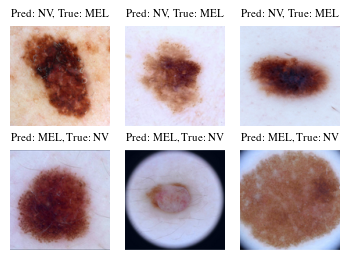

In [38]:
import torch
import matplotlib.pyplot as plt

def plot_specific_misclassified_images(model, loader, device, classes=['MEL', 'NV'], num_images_per_row=8):
    model.eval()  # Set the model to evaluation mode
    misclassified_pred_nv_true_mel = []
    misclassified_pred_mel_true_nv = []

    with torch.no_grad():
        for images, labels in loader:
            if len(misclassified_pred_nv_true_mel) >= num_images_per_row and len(misclassified_pred_mel_true_nv) >= num_images_per_row:
                break  # Stop if we have enough samples

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(images.size(0)):
                if preds[i] != labels[i]:
                    if preds[i] == classes.index('NV') and labels[i] == classes.index('MEL'):
                        if len(misclassified_pred_nv_true_mel) < num_images_per_row:
                            misclassified_pred_nv_true_mel.append(images[i])
                    elif preds[i] == classes.index('MEL') and labels[i] == classes.index('NV'):
                        if len(misclassified_pred_mel_true_nv) < num_images_per_row:
                            misclassified_pred_mel_true_nv.append(images[i])

    # Plotting
    fig, axes = plt.subplots(2, num_images_per_row, figsize=(num_images_per_row*1.2, 2.7))
    for idx, (image_set, title) in enumerate(zip([misclassified_pred_nv_true_mel, misclassified_pred_mel_true_nv], 
                                                  ["Pred: NV, True: MEL", "Pred: MEL, True: NV"])):
        for i, image in enumerate(image_set):
            ax = axes[idx, i]
            img = image.cpu().numpy().transpose((1, 2, 0))  # Convert from tensor image
            img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
            ax.imshow(img)
            ax.set_title(title, fontsize=8)
            ax.axis('off')
    plt.tight_layout()
    

    plt.savefig('misclassifications.pdf', format='pdf', bbox_inches='tight')

    plt.show()

plot_specific_misclassified_images(resnet_model, test_loader, device, classes=['MEL', 'NV'], num_images_per_row=3)

In [15]:
predicted_labels, true_labels = generate_labels_and_true(resnet_model, test_blind_loader, device)

with open('labels_test_91.45.txt', 'w') as f:
    for label in predicted_labels:
        f.write(f"{'NV' if label else 'MEL'}\n")
        
with open('labels_test_91.45.txt') as f:
    guesses = [l.strip() for l in f]
    assert(len(guesses) == 1366)
    assert(sorted(set(guesses)) == ['MEL', 'NV'])

In [16]:
len(predicted_labels)

1366